# Classification of reviews using BERT

In this notebook, I have done review text classification with Hugging Face Transformers in ktrain. ktrain is a library to help build, train, debug and deploy neural networks in the keras deep learning framework. It uses tf.keras in the Tensorflow library. Using ktrain, optimal learning rate is found first, followed by model traning using learning rate schedules such as 1cycle policy.The misclassified texts are also easily found using ktrain. At last I have saved the model to predict new data.

Lets start working on BERT by mounting drive and installing ktrain.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
pip install ktrain

     |████████████████████████████████| 25.3MB 1.8MB/s 
     |████████████████████████████████| 6.8MB 50.3MB/s 
     |████████████████████████████████| 983kB 47.1MB/s 
     |████████████████████████████████| 266kB 50.2MB/s 
     |████████████████████████████████| 1.9MB 43.2MB/s 
     |████████████████████████████████| 1.2MB 46.0MB/s 
     |████████████████████████████████| 471kB 47.3MB/s 
     |████████████████████████████████| 3.3MB 44.8MB/s 
     |████████████████████████████████| 901kB 40.3MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.2-cp37-none-any.whl size=25277794 sha256=e5cd311c5e782c33adc8f5916f22de40866d5a51d309899590ac63d24360e4c7
  Stored in directory: /root/.cache/pip/wheels/67/2e/f1/c72afa08df8b2d984b910dea228902ce81dae4511afe9fafd2
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=e1ead02f5334af1c56452439460fba6f8e0e9e0398674d4d954ef7f0d81fe7bb
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d4

In [79]:
#to plot confusion matrix
pip install mlxtend

In [6]:
#import the necessary libraries
import tensorflow as tf
import numpy as np
import ktrain
from ktrain import text
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt 
%matplotlib inline

In [7]:
#Read the csvs
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/Capstone_project/reviews_preprocessed.csv',dtype='unicode',usecols = ['reviewerID','product_id','ratings','reviewcomb','ratings'])

In [5]:
df.head()

,reviewerID,product_id,ratings,reviewcomb
0,A11LNPG39A2ZV4,B00063M3EC,5.0,"I've been using&nbsp;<a data-hook=""product-lin..."
1,A1VUN4JU731CBH,B00063M3EC,5.0,I had seen the Marvis toothpastes before and a...
2,A2CBVSJ1OV2Q4S,B00063M3EC,5.0,I buy the Jasmine Marvis Toothpaste because it...
3,A34XM0ECYBB4DH,B00063M3EC,5.0,This toothpaste is the best I've ever tried. ...
4,A2PMRY7ADA8WJ2,B00063M3EC,5.0,i didn't know what i was missing until i tried...


In [6]:
df.shape

(464829, 4)

In [7]:
df.isnull().sum()

reviewerID    0
product_id    0
ratings       0
reviewcomb    0
dtype: int64

In [8]:
df.shape

(464829, 4)

In [9]:
df.dtypes

reviewerID    object
product_id    object
ratings       object
reviewcomb    object
dtype: object

In [8]:
#Convert to appropriate datatype
df['ratings'] = df['ratings'].astype(float)


In [9]:
#Defining positive and negative sentiment
df['Sentiment_rating']=np.where(df.ratings>3,1,0)

df = df[df.ratings !=3]

df['Sentiment_rating'].value_counts(normalize=True)

1    0.838456
0    0.161544
Name: Sentiment_rating, dtype: float64

Replace the ratings 1,2 as  negative rating and 4,5 as positive rating.

In [10]:
#map positive and negative to 1 and 0 respectively
df['Sentiment_rating'] = df['Sentiment_rating'].replace(to_replace = [1,0],value = ['pos','neg'])
df

,reviewerID,product_id,ratings,reviewcomb,Sentiment_rating
0,A11LNPG39A2ZV4,B00063M3EC,5.0,"I've been using&nbsp;<a data-hook=""product-lin...",pos
1,A1VUN4JU731CBH,B00063M3EC,5.0,I had seen the Marvis toothpastes before and a...,pos
2,A2CBVSJ1OV2Q4S,B00063M3EC,5.0,I buy the Jasmine Marvis Toothpaste because it...,pos
3,A34XM0ECYBB4DH,B00063M3EC,5.0,This toothpaste is the best I've ever tried. ...,pos
4,A2PMRY7ADA8WJ2,B00063M3EC,5.0,i didn't know what i was missing until i tried...,pos
...,...,...,...,...,...
464823,A3IRO9Y2W7DGXU,B01HIQCSBC,5.0,My wife bought it and loves it. She says paint...,pos
464824,A2HPJMRRTYJ2M9,B01HIQCSBC,5.0,CND Shellac Power Polish is wonderful! This co...,pos
464825,A37M9GZV5PMABX,B01HIQCSBC,2.0,"the colour is too dark, Two Stars",neg
464827,A2VVJW6PY48A9M,B01HIQCSBC,5.0,"Great product, PERFECT SHADE!! :) Love the de...",pos


In [13]:
df.shape

(428757, 5)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428757 entries, 0 to 464828
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   reviewerID        428757 non-null  object 
 1   product_id        428757 non-null  object 
 2   ratings           428757 non-null  float64
 3   reviewcomb        428757 non-null  object 
 4   Sentiment_rating  428757 non-null  object 
dtypes: float64(1), object(4)
memory usage: 39.6+ MB


In [11]:
X = df['reviewcomb']
y=df['Sentiment_rating']

In [12]:
categories = ['neg','pos']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,random_state=42,test_size=0.2)

In [14]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [15]:
X_train.shape, y_train.shape, X_test.shape

((343005,), (343005,), (85752,))

# Preprocess Data and Build model with Transformer

In [20]:
#Specify model
model_name = 'distilbert-base-uncased'

trans = text.Transformer(model_name, maxlen = 100, class_names = categories)

In [21]:
train_data = trans.preprocess_train(X_train,y_train)
test_data = trans.preprocess_test(X_test,y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 48
	95percentile : 148
	99percentile : 282


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 47
	95percentile : 148
	99percentile : 282


In [23]:
model = trans.get_classifier()

# Find optimal learning rate

In [24]:
learner = ktrain.get_learner(model, train_data = train_data, val_data = test_data, batch_size =16)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
21437/21437 [==============================] - 1575s 70ms/step - loss: 0.2911 - accuracy: 0.8838
Epoch 2/3
21437/21437 [==============================] - 1386s 65ms/step - loss: 0.2372 - accuracy: 0.9134


done.
Visually inspect loss plot and select learning rate associated with falling loss


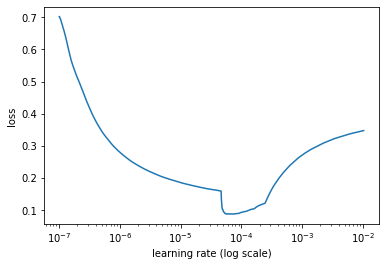

In [ ]:
#Get optimal learning rate
learner.lr_find(show_plot=True, max_epochs = 3)

In [ ]:
learner

# Train the model

In [25]:
history = learner.fit_onecycle(2e-5, 1) #1 epoch 



begin training using onecycle policy with max lr of 2e-05...
21438/21438 [==============================] - 2872s 129ms/step - loss: 0.1203 - accuracy: 0.9540 - val_loss: 0.0539 - val_accuracy: 0.9797


# Evaluate Model

In [26]:
learner.validate(class_names = categories)

              precision    recall  f1-score   support

         neg       0.94      0.94      0.94     13853
         pos       0.99      0.99      0.99     71899

    accuracy                           0.98     85752
   macro avg       0.96      0.96      0.96     85752
weighted avg       0.98      0.98      0.98     85752



array([[12976,   877],
       [  861, 71038]])

# Misclassified reviews

In [27]:
learner.view_top_losses(n=5, preproc = trans)

----------
id:32431 | loss:8.97 | true:neg | pred:pos)

----------
id:26369 | loss:8.72 | true:neg | pred:pos)

----------
id:48728 | loss:8.72 | true:neg | pred:pos)

----------
id:76607 | loss:8.62 | true:neg | pred:pos)

----------
id:76056 | loss:8.48 | true:neg | pred:pos)



# Save model

In [58]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [35]:
predictor.save('gdrive/My Drive/Capstone_project/models/distilbert1')

# Predict on new data

In [59]:
predictor.predict('This product is not the best on the market')

'neg'

In [60]:
predictor.predict('like how it gives glowing skin')

'pos'

In [61]:
predictor.predict('not a horrible one')

'pos'

In [62]:
predictor.predict('acne')

'neg'

In [ ]:
# history = ktrain.load_predictor('gdrive/My Drive/Capstone_project/models/distilbert1')

#Confusion Matrix

In [63]:
y_pred = predictor.predict(X_test)

In [ ]:
import matplotlib as plt
plt.rcParams.update(plt.rcParamsDefault)

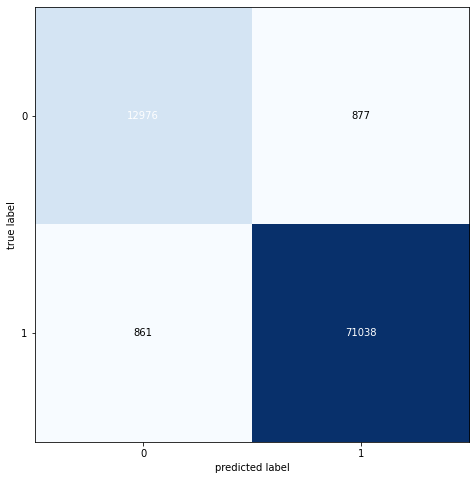

In [106]:
mat = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat = mat, figsize = (8,8),  show_normed =False)

In [74]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[12976,   877],
       [  861, 71038]])

In [111]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()

In [113]:
fpr= fp/(fp+tn)
fpr

0.06330758680430232

Using ktrain with Distilbert transformers, my model needed only one epoch to train and the accuracy of the model also seems to be high compared to the previous ones. Also the FPR is 0.06 compared to Logistic Regression(0.29) and BiLSTM(0.162). Some of the False negatives are due to shorter review length and spelling mistakes that were made in the review. These findings can be used the users when they are overwhelmed by the number of reviews to go through before buying and also by sellers to find the quality of products.

Another thing that I want to consider in the future to check whether the reviews were done by verified customers as the fake reviews by bots and also by some agents to promote their products are widely done these days. This way the classifier would be able to accurately classify  and recommenders would be able to serve quality recommendations using sentiment analysis.